# Clustering

## I. Imports & functions

In [410]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from tslearn.metrics import dtw
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from dtaidistance import dtw_ndim
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score, adjusted_rand_score, adjusted_mutual_info_score

import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

In [452]:
def plot_clustering(countries, labels):
    """
    Plot a map of Europe with identified clusters of countries
    """
    fig = px.choropleth(countries, locations = 'countrycode', color = labels, projection='conic conformal')
    fig.update_geos(lataxis_range=[35, 75], lonaxis_range=[-15, 45])
    fig.show()
    
def plot_dendrogram(model):
    """
    Create linkage matrix and then plot the dendrogram
    """
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix)

def kmeans_clustering(data, n_clusters):
    """
    KMeans
    """
    data_agg = data.drop('year', axis=1).groupby(['countrycode', 'country']).agg(list)
    n_countries = data_agg.shape[0]
    time_range =  len(data['year'].drop_duplicates())
    n_vars = data.shape[1] - 3
    data_agg_arr = np.empty(shape=(n_countries, n_vars, time_range))
    for i in range(data_agg.shape[0]):
        for j in range(data_agg.shape[1]):
            data_agg_arr[i][j] = np.array(data_agg.iloc[i,j])
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric='dtw')
    model.fit(data_agg_arr)
    return model, model.labels_

def agglomerative_clustering(data, n_clusters, linkage):
    """
    Agglomerative
    """
    data_t = data.melt(id_vars=['countrycode','country','year'])
    data_t = data_t.groupby(['countrycode','country','year','variable'])['value'].aggregate('mean').unstack('year')
    data_t = data_t.reset_index().drop('variable', axis=1).groupby(['countrycode', 'country']).agg(list)
    n_countries = data_t.shape[0]
    time_range =  data_t.shape[1]
    n_vars = data.shape[1] - 3
    data_t_arr = np.empty(shape=(n_countries, time_range, n_vars))
    for i in range(n_countries):
        for j in range(time_range):
            data_t_arr[i][j] = np.array(data_t.iloc[i,j])
    dtw_matrix = dtw_ndim.distance_matrix(data_t_arr, n_vars)
    model = AgglomerativeClustering(
        n_clusters=n_clusters, affinity='precomputed', linkage=linkage, compute_distances=True)
    model.fit(dtw_matrix)
    return model, model.labels_

def dbscan_clustering(data, eps, min_samples):
    """
    DBSCAN
    """
    data_t = data.melt(id_vars=['countrycode','country','year'])
    data_t = data_t.groupby(['countrycode','country','year','variable'])['value'].aggregate('mean').unstack('year')
    data_t = data_t.reset_index().drop('variable', axis=1).groupby(['countrycode', 'country']).agg(list)
    n_countries = data_t.shape[0]
    time_range =  data_t.shape[1]
    n_vars = data.shape[1] - 3
    data_t_arr = np.empty(shape=(n_countries, time_range, n_vars))
    for i in range(n_countries):
        for j in range(time_range):
            data_t_arr[i][j] = np.array(data_t.iloc[i,j])
    dtw_matrix = dtw_ndim.distance_matrix(data_t_arr, n_vars)
    model = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
    model.fit(dtw_matrix)
    return model, model.labels_

def evaluate_clustering(data, labels1, labels2, labels3):
    sil_score = [silhouette_score(data, labels1, metric='precomputed'), 
            silhouette_score(data, labels2, metric='precomputed'), 
            silhouette_score(data, labels3, metric='precomputed')]
    results = pd.DataFrame([sil_score], columns=['Kmeans', 'Agg', 'DBSCAN'], 
    index=['Silhouette'])
    return results



## II. Data

In [412]:
data = pd.read_csv('data/data.csv')
data.head()

,countrycode,country,year,pop,rgdpna,delta,xr,csh_c,csh_i,csh_g,csh_x,csh_m,csh_r,rgdpna_per_cap,emp_percent,co2_emission,employment_agro,employment_industry,employment_services,export,import,inflation,net_migration,population_15_64,population_above_65,population_under_14,unemployment,urban_population,hdi
0,ALB,Albania,1990,0.020266,0.001841,0.151999,0.088576,0.475201,0.093659,0.317663,0.018863,0.954592,0.158237,0.021368,0.466870,0.040463,0.995473,0.023282,0.040798,0.035778,0.234066,0.026795,0.093730,0.045050,0.012636,0.995734,0.428295,0.008616,0.051255
1,ALB,Albania,1991,0.020158,0.001765,0.146769,0.122181,0.484793,0.087354,0.330491,0.018106,0.947753,0.157691,0.020529,0.450952,0.035597,0.993862,0.023786,0.042039,0.035841,0.258771,0.030538,0.097011,0.038567,0.017593,0.995729,0.429421,0.012412,0.042410
2,ALB,Albania,1992,0.020010,0.001737,0.140639,0.167289,0.487556,0.087580,0.339263,0.016650,0.942814,0.164122,0.020431,0.434157,0.030689,0.990899,0.024757,0.044296,0.036417,0.272822,0.032010,0.102411,0.031683,0.024157,0.994572,0.430850,0.017598,0.036869
3,ALB,Albania,1993,0.019828,0.001777,0.134270,0.221561,0.479223,0.095106,0.348672,0.014622,0.940917,0.179091,0.021354,0.419071,0.026408,0.986223,0.026156,0.047938,0.036917,0.269351,0.030130,0.110334,0.026117,0.032217,0.991197,0.432400,0.024219,0.037571
4,ALB,Albania,1994,0.019638,0.001881,0.128552,0.279895,0.459342,0.107618,0.369705,0.012502,0.941699,0.198760,0.023224,0.407361,0.023288,0.979889,0.027685,0.053085,0.036798,0.249430,0.025328,0.120462,0.024476,0.041217,0.984334,0.433774,0.032028,0.045982


In [413]:
countries = data[['countrycode','country']].drop_duplicates()

## III. Multivariate time series clustering

### III.I Kmeans

In [441]:
kmeans_ts, y_kmeans_ts = kmeans_clustering(data, 4)
plot_clustering(countries, y_kmeans_ts)

### III.II Agglomerative clustering

In [415]:
agg_ts, y_agg_ts = agglomerative_clustering(data, 4, 'complete')
plot_clustering(countries, y_agg_ts)

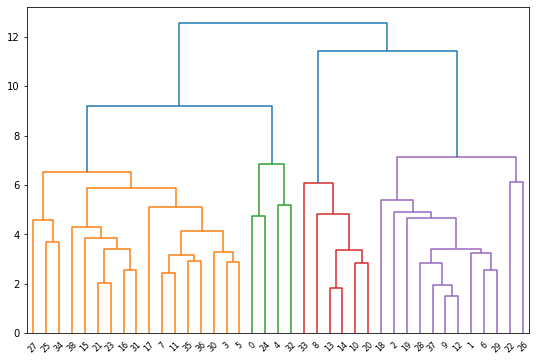

In [416]:
plot_dendrogram(agg_ts)

### III.III OPTICS

In [469]:
# tuning hyperparameters
min_grid = [x for x in range(2, 39, 1)]
eps_grid = np.arange(0.1, 10, 0.1)
best_params = {}
for m in min_grid:
    for e in eps_grid:
        dbscan = DBSCAN(eps = e, min_samples = m, metric='precomputed').fit(dtw_matrix)
        labels = dbscan.labels_
        if len(set(labels)) > 2:
            cal_score = silhouette_score(dtw_matrix, labels, metric='precomputed')

            if cal_score > 0:
                best_params[str(m) + " - " + str(e)] = cal_score
                
max_key = max(best_params, key = best_params.get)
print("parameter values are: ", max_key)
print("maximum silhouette score value is: ", best_params[max_key])

parameter values are:  2 - 3.2
maximum silhouette score value is:  0.11733396718909048


In [467]:
dbscan_ts, y_dbscan_ts = dbscan_clustering(data, 3.2, 2)
plot_clustering(countries, y_dbscan_ts)

In [468]:
evaluate_clustering(dtw_matrix, y_kmeans_ts, y_agg_ts, y_dbscan_ts )

,Kmeans,Agg,DBSCAN
Silhouette,0.178252,0.238829,0.117334


## IV. Flat data clustering

In [419]:
data_flat = data.melt(id_vars=['countrycode', 'country', 'year'])
data_flat['variable'] = data_flat['variable'] + '_' + data_flat['year'].astype(str)
data_flat.drop('year', axis=1, inplace=True)
data_flat = data_flat.groupby(['countrycode', 'country', 'variable'])['value'].aggregate('mean').unstack().reset_index()

### IV.I KMeans

In [420]:
kmeans = KMeans(n_clusters=4)
y_kmeans = kmeans.fit_predict(data_flat.iloc[:, 2:])

In [421]:
plot_clustering(countries, y_kmeans)

In [422]:
k_max = 10
inertias = []
for k in range(1, k_max+1):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(data_flat.iloc[:, 2:])
    inertias.append(kmeans.inertia_)

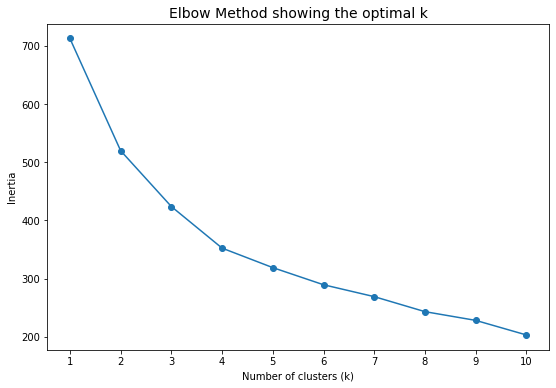

In [423]:
elbow = plt.plot(list(range(1, len(inertias) + 1)), inertias, '-o')
plt.title('Elbow Method showing the optimal k', size=14)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(list(range(1, len(inertias) + 1)));

In [424]:
k_max = 15
silhouette = []
for k in range(2, k_max+1):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    silhouette.append(silhouette_score(data_flat.iloc[:, 2:], kmeans.fit_predict(data_flat.iloc[:, 2:])))

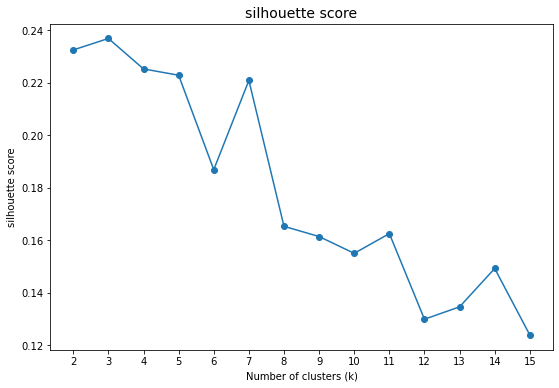

In [425]:
elbow = plt.plot(list(range(2, len(silhouette)+2 )), silhouette, '-o')
plt.title('silhouette score', size=14)
plt.xlabel('Number of clusters (k)')
plt.ylabel('silhouette score')
plt.xticks(list(range(2, len(silhouette)+2 )));

### IV.II AgglomerativeClustering

In [426]:
agglomerative = AgglomerativeClustering(linkage = 'complete', n_clusters = 4)
y_agg = agglomerative.fit_predict(data_flat.iloc[:, 2:])

In [427]:
plot_clustering(countries, y_agg)

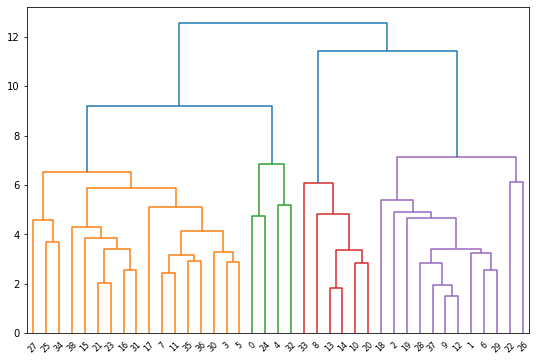

In [428]:
plot_dendrogram(agg)

### IV.III OPTICS

In [429]:
# POPRAWIC NA OPTICS
# # tuning hyperparameters
# min_grid = [x for x in range(2, 39, 1)]
# eps_grid = np.arange(0.1, 5, 0.1)
# best_params = {}
# for m in min_grid:
#     for e in eps_grid:
#         dbscan = DBSCAN(eps = e, min_samples = m).fit(data_flat.iloc[:, 2:])
#         labels = dbscan.labels_

#         if len(set(labels)) > 1:
#             cal_score = calinski_harabasz_score(data_flat.iloc[:, 2:], labels)

#             if cal_score > 0:
#                 best_params[str(m) + " - " + str(e)] = cal_score
                
# max_key = max(best_params, key = best_params.get)
# print("parameter values are: ", max_key)
# print("maximum calinski-harabasz score value is: ", best_params[max_key])

In [430]:
opt = OPTICS() # parametry
y_opt = opt.fit_predict(data_flat.iloc[:, 2:])

In [431]:
plot_clustering(countries, y_opt)